# Introduction

In this notebook, we conduct a systematic exploration and preparation of the dataset to ensure its suitability for downstream machine learning tasks. Our workflow includes three major components:

1. **Data Understanding** – We perform an initial inspection of the dataset structure, identify inconsistencies, detect missing or anomalous values, and evaluate variable types and distributions.

2. **Data Cleaning** – We address quality issues by handling missing values, correcting data types, removing or transforming invalid entries, and resolving encoding artifacts. 

3. **Label Construction for Classification Tasks** – We define and generate the target variables needed for our classification tasks, ensuring that labels are accurate, interpretable, and aligned with the clinical objectives of the study.

By the end of this workflow, the dataset will be fully cleaned, well-structured, and ready to be used for training and evaluating machine learning models.


### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import HTML

### Utility Functions

This section contains a set of small helper functions that will be used throughout the notebook. 

#### Scrollable DataFrame Display Function

In [2]:
def display_scrollable_dataframe(df, height=300):
    """
    Display a pandas DataFrame inside a scrollable HTML container.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to display.
    height : int, optional (default=300)
        The maximum height (in pixels) of the visible table area.
        If the table is taller than this value, a vertical scrollbar 
        will appear.

    Returns
    -------
    IPython.display.HTML
        An HTML block containing the CSS rules that constrain the 
        table height and enable scrolling.

    Notes
    -----
    This function improves readability in Jupyter notebooks when the 
    DataFrame contains many rows. Instead of printing the entire table 
    (which may take a lot of vertical space), the output is shown inside 
    a fixed-height container with a scroll bar.
    """
    
    # Display the DataFrame normally (converted to HTML)
    display(HTML(df.to_html()))

    # Inject CSS that limits the table height and enables scrolling
    return HTML(f"""
    <style>
        table {{
            display: block;
            max-height: {height}px;
            overflow-y: scroll;
        }}
    </style>
    """)


#### BoxPlot Function

In [3]:
def boxplot_func(
    col, 
    data_frame, 
    whis=1.5, 
    ylim_factor=0.2,
    yscale=None, 
    title=None,
    figsize=(6, 6)
):
    """
    Draw a clean boxplot for a single continuous variable.

    Parameters
    ----------
    col : str
        Column name to plot.
    data_frame : pd.DataFrame
        DataFrame containing the column.
    whis : float, optional
        Tukey whisker parameter (default 1.5).
    ylim_factor : float, optional
        Percentage padding around whiskers for zooming.
    yscale : str, optional
        y-axis scale ("linear", "log", etc.).
    title : str, optional
        Custom title.
    figsize : tuple, optional
        Figure size.
    """

    series = data_frame[col].dropna()

    # compute whiskers using a hidden boxplot
    fig, ax = plt.subplots()
    bp = ax.boxplot(series, vert=True, whis=whis, showfliers=True)
    plt.close(fig)

    lower_w = bp["whiskers"][0].get_ydata()[1]
    upper_w = bp["whiskers"][1].get_ydata()[1]

    # Zoom limits
    ymin = lower_w - abs(lower_w) * ylim_factor
    ymax = upper_w + abs(upper_w) * ylim_factor

    # Actual plot
    plt.figure(figsize=figsize)
    plt.boxplot(series, vert=True, whis=whis, showfliers=True)
    plt.ylim(ymin, ymax)

    if yscale:
        plt.yscale(yscale)

    plt.title(title if title else f"Boxplot for {col}")
    plt.ylabel(col)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


#### Multi BoxPlot Single Page Function

In [4]:
def plot_boxplots_single_page(
    data,
    columns,
    cols_per_row=4,
    whis=1.5,
    figsize=(16, 8),
):
    """
    Plot boxplots for a list of columns on a single page and compute
    Tukey-based statistics for each column.

    Parameters
    ----------
    data : pd.DataFrame
        The dataset.
    columns : list of str
        List of column names to plot.
    cols_per_row : int, optional
        Number of subplots per row (default is 4).
    whis : float, optional
        Tukey whisker parameter (default is 1.5).
    figsize : tuple, optional
        Figure size for the page (default is (16, 8)).

    Returns
    -------
    pd.DataFrame
        DataFrame with per-column statistics:
        - Q1, Q3, IQR
        - lower_bound, upper_bound
        - non_null, within_whiskers, outside_whiskers
        - pct_within_non_null, pct_outside_non_null
        - pct_within_total_rows, pct_outside_total_rows
    """
    stats = []
    n_rows_total = len(data)
    n = len(columns)
    rows = math.ceil(n / cols_per_row)

    fig, axes = plt.subplots(rows, cols_per_row, figsize=figsize)
    axes = np.atleast_1d(axes).flatten()

    for ax, col in zip(axes, columns):
        if col not in data.columns:
            ax.set_title(f"{col} (missing in data)", fontsize=9)
            ax.axis("off")

            stats.append({
                "column": col,
                "Q1": np.nan,
                "Q3": np.nan,
                "IQR": np.nan,
                "lower_bound": np.nan,
                "upper_bound": np.nan,
                "non_null": 0,
                "within_whiskers": 0,
                "outside_whiskers": 0,
                "pct_within_non_null": np.nan,
                "pct_outside_non_null": np.nan,
                "pct_within_total_rows": 0.0,
                "pct_outside_total_rows": 0.0,
            })
            continue

        series = data[col]
        non_null_series = series.dropna()

        if non_null_series.empty:
            ax.set_title(f"{col} (all NaN)", fontsize=9)
            ax.axis("off")

            stats.append({
                "column": col,
                "Q1": np.nan,
                "Q3": np.nan,
                "IQR": np.nan,
                "lower_bound": np.nan,
                "upper_bound": np.nan,
                "non_null": 0,
                "within_whiskers": 0,
                "outside_whiskers": 0,
                "pct_within_non_null": np.nan,
                "pct_outside_non_null": np.nan,
                "pct_within_total_rows": 0.0,
                "pct_outside_total_rows": 0.0,
            })
            continue

        # Draw boxplot
        ax.boxplot(non_null_series, whis=whis, showfliers=True)
        ax.set_title(col, fontsize=9)
        ax.grid(True, linestyle="--", alpha=0.3)

        # Compute Tukey fences
        Q1 = non_null_series.quantile(0.25)
        Q3 = non_null_series.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - whis * IQR
        upper_bound = Q3 + whis * IQR

        # Masks
        mask_non_null = series.notna()
        mask_within = mask_non_null & (series >= lower_bound) & (series <= upper_bound)

        non_null_count = mask_non_null.sum()
        within_count = mask_within.sum()
        outside_count = non_null_count - within_count

        pct_within_non_null = (
            within_count / non_null_count * 100 if non_null_count > 0 else np.nan
        )
        pct_outside_non_null = (
            outside_count / non_null_count * 100 if non_null_count > 0 else np.nan
        )
        pct_within_total = within_count / n_rows_total * 100
        pct_outside_total = outside_count / n_rows_total * 100

        stats.append({
            "column": col,
            "Q1": Q1,
            "Q3": Q3,
            "IQR": IQR,
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
            "non_null": int(non_null_count),
            "within_whiskers": int(within_count),
            "outside_whiskers": int(outside_count),
            "pct_within_non_null": pct_within_non_null,
            "pct_outside_non_null": pct_outside_non_null,
            "pct_within_total_rows": pct_within_total,
            "pct_outside_total_rows": pct_outside_total,
        })

    # Hide unused axes if there are fewer columns than grid slots
    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    stats_df = pd.DataFrame(stats).set_index("column")
    return stats_df

#### Remove BoxPlot Outliers Function

In [5]:
def remove_boxplot_outliers(data_frame, col, whis=1.5, verbose=True):
    """
    Remove outliers based on Tukey fences for a single column.

    Parameters
    ----------
    data_frame : pd.DataFrame
        Original dataset.
    col : str
        Column to clean.
    whis : float
        Tukey whisker parameter.

    Returns
    -------
    pd.Series
        A series where values outside whiskers are set to NaN.
    """
    series = data_frame[col]

    # If all NaN or constant, just return as-is
    if series.dropna().nunique() <= 1:
        if verbose:
            print(f"{col}: skipped (all NaN or constant)\n")
        return series

    # Compute quartiles and IQR
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # Tukey fences
    lower_bound = Q1 - whis * IQR
    upper_bound = Q3 + whis * IQR

    # Remove outliers
    cleaned = series.mask((series < lower_bound) | (series > upper_bound), np.nan)

    if verbose:
        print(f"{col}:")
        print(f"  Q1 = {Q1:.2f}, Q3 = {Q3:.2f}, IQR = {IQR:.2f}")
        print(f"  Lower bound = {lower_bound:.2f}")
        print(f"  Upper bound = {upper_bound:.2f}")
        print(f"  Outliers removed = {(series.isna() != cleaned.isna()).sum()}\n")

    return cleaned

In [6]:
def clean_columns_with_boxplot_outliers(
    df,
    columns,
    whis=1.5,
    verbose=True,
):
    """
    Apply Tukey-based outlier removal to a list of columns.

    Parameters
    ----------
    df : pd.DataFrame
        Original dataset.
    columns : list of str
        Columns to clean.
    whis : float, optional
        Tukey whisker parameter (default is 1.5).
    verbose : bool, optional
        If True, prints a short summary per column.

    Returns
    -------
    pd.DataFrame
        Copy of the dataframe where outliers in the selected columns
        are set to NaN.
    """
    df_clean = df.copy()

    for col in columns:
        if col not in df_clean.columns:
            if verbose:
                print(f"{col}: column not present in dataframe, skipping.\n")
            continue

        cleaned_series = remove_boxplot_outliers(
            df_clean,
            col,
            whis=whis,
            verbose=verbose,
        )
        df_clean[col] = cleaned_series

    return df_clean

### Data Loading

We load the CSV file using a more explicit configuration to avoid warnings.  
If we used the default settings, Pandas would raise a `DtypeWarning` because it would not correctly infer the date column while reading the file in chunks.  

By disabling chunking (`low_memory=False`) and explicitly parsing the date column (`parse_dates=[7]`), the import becomes slightly slower but much more accurate and stable. Other date columns are converted manually for the same reason.

We also adjust the **display options** to make the initial inspection easier during the analysis.


In [7]:
current_dir = os.getcwd()
main_dir = os.path.abspath(os.path.join(current_dir, "..", ".."))

# Read the CSV with explicit date parsing to avoid dtype warnings
data = pd.read_csv(main_dir +
    '/Datasets/UKDataset/UKdata.csv',
    parse_dates=[7],
    dayfirst=False,
    low_memory=False
)

# Convert additional known date columns using a safe parser
data["Death_date"] = pd.to_datetime(data["Death_date"], errors="coerce")
data["Vdate_0"]    = pd.to_datetime(data["Vdate_0"], errors="coerce")

# Display all columns and increase row visibility for early inspection
pd.options.display.max_columns = None
pd.options.display.max_rows = None

---

# Data Understanding

We begin the data understanding phase by inspecting the dataset structure. This gives us an initial overview of the dataset and helps identify potential inconsistencies (e.g., columns parsed as `object` instead of numeric).

We also check whether the dataset contains duplicated entries. As we can see, this doesn't occur.


In [8]:
print("Shape:", data.shape)
print()

print("Data info:")
data.info()
print()

print("Data types:")
print(data.dtypes.value_counts())

print("\n=== Object columns ===")
object_cols = data.select_dtypes(include="object").columns
print(list(object_cols))

print("\n=== Datetime columns ===")
datetime_cols = data.select_dtypes(include="datetime").columns
print(list(datetime_cols))


print()
duplicate_count = data.duplicated().sum()
print("Number of duplicated rows:", duplicate_count)


Shape: (502412, 293)

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502412 entries, 0 to 502411
Columns: 293 entries, Sex to Familiarity_siblings__Prostate_cancer__0
dtypes: datetime64[ns](3), float64(165), int64(124), object(1)
memory usage: 1.1+ GB

Data types:
float64           165
int64             124
datetime64[ns]      3
object              1
Name: count, dtype: int64

=== Object columns ===
['Cause_of_death']

=== Datetime columns ===
['Vdate_0', 'Lost_FU', 'Death_date']

Number of duplicated rows: 0


### Columns Overview

In this section, we perform a general assessment of all dataset columns to better understand their structure and suitability for further analysis.  

We start verifying whether any columns contain only a single unique value. We find that **two columns exhibit no meaningful variability**, containing either a single recorded value or almost exclusively missing data:

- **`Urine_microalb_flag_0`** — this flag variable contains only the value *1.0* (indicating microalbumin below the detection limit) together with many missing entries.  
- **`Med_cbd_2_0`** — this medication-related field is almost entirely missing, with only a small number of entries equal to *3.0*.


In [9]:
# Find constant columns
constant_cols = data.columns[data.nunique() == 1]

print("Constant columns found:\n")
for col in constant_cols:
    print(f"- {col}")

print("\nDetails for constant columns:\n")

for col in constant_cols:
    print(f"Column: {col}")
    print("Value counts:")
    print(data[col].value_counts(dropna=False))
    print("NaN count:", data[col].isna().sum())
    print("-" * 40)



Constant columns found:

- Urine_microalb_flag_0
- Med_cbd_2_0

Details for constant columns:

Column: Urine_microalb_flag_0
Value counts:
Urine_microalb_flag_0
1.0    331328
NaN    171084
Name: count, dtype: int64
NaN count: 171084
----------------------------------------
Column: Med_cbd_2_0
Value counts:
Med_cbd_2_0
NaN    500491
3.0      1921
Name: count, dtype: int64
NaN count: 500491
----------------------------------------


We examine the proportion of missing values across all columns in the dataset. We compute both the absolute number of missing entries and their percentage relative to the total number of records. To focus on variables with substantial missingness, we filter and display only the columns where more than **10%** of the values are missing. 

In [10]:
# Missing values summary (ranked + percentage)
missing_df = (
    data.isna()
        .sum()
        .to_frame(name="missing_count")
        .assign(missing_pct=lambda x: x["missing_count"] / len(data) * 100)
        .sort_values("missing_count", ascending=False)
)

threshold = 10
filtered_missing_df = missing_df[missing_df["missing_pct"] > threshold]

# Horizontal display
# filtered_missing_df.T
display_scrollable_dataframe(filtered_missing_df, height=300)



,missing_count,missing_pct
Months_from_first_malnutrition_DM,502405,99.998607
Arm_right_impendance_manual_0,502387,99.995024
Wbody_impedance_manual_0,502387,99.995024
Arm_left_impendance_manual_0,502387,99.995024
Leg_right_impendance_manual_0,502387,99.995024
Leg_left_impendance_manual_0,502387,99.995024
Med_cbde_3_0,502319,99.981489
Months_from_first_hypertension_pregnancy,502282,99.974125
PWV_manual_0,502251,99.967955
Months_from_first_secondary_hypertension,502114,99.940686


We distinguish numeric columns that behave as **binary variables** (i.e., columns containing exactly two distinct values) from those that have a broader numeric range.

The first code block counts how many numeric columns are binary and how many are not.  
The second block performs a range analysis **only** on the non-binary numeric columns to avoid meaningless min/max summaries for true binary variables.


In [11]:
# Select numeric columns
num_data = data.select_dtypes(include="number")

# Count distinct values per numeric column
unique_counts = num_data.nunique()

# Binary = exactly two unique values
binary_cols = unique_counts[unique_counts == 2].index

# Non-binary = more than two unique values
non_binary_cols = unique_counts[unique_counts > 2].index

print("Number of binary numeric columns:", len(binary_cols))
print("Number of non-binary numeric columns:", len(non_binary_cols))


Number of binary numeric columns: 132
Number of non-binary numeric columns: 155


In [12]:
num_data_non_binary = num_data[non_binary_cols]

num_data_non_binary.agg(["min", "max"])


,WC_0,HC_0,Height_S_0,Height_s_0,Vmonth_0,Walks_duration_0,Duration_moderate_0,Duration_vigorous_0,Sleep_0,Smoke_t_c_0,Smoke_t_p_0,Alcohol_i_f_0,Weight_manual_0,Age_start_smoke_0,Immigration_year_0,PR_0,PW_ri_0,PW_ptp_0,PW_pp_0,PW_pn_0,PW_sp_0,PWV_manual_0,Wbody_impedance_manual_0,Leg_right_impendance_manual_0,Leg_left_impendance_manual_0,Arm_right_impendance_manual_0,Arm_left_impendance_manual_0,Height_s_0.1,Height_s_1.1,Height_s_2.1,Height_s_3.1,Smoking_status_0,Alcohol_status_0,Pack_years_0,Pack_years_proportion_0,BMI_0,Weight_0,Age_visit_0,PW_AS_index_0,IPAQ_activity_group,Whole_body_fat_perc_0,Whole_body_fat_mass_0,Whole_body_fatfree_0,Whole_body_water_0,Whole_body_impedance_0,Leg_right_impedance_0,Leg_left_impedance_0,Arm_right_impedance_0,Arm_left_impedance_0,Leg_right_fat_perc_0,Leg_right_fat_mass_0,Leg_right_fatfree_0,Leg_right_predictedmass_0,Leg_left_fat_perc_0,Leg_left_fat_mass_0,Leg_left_fatfree_0,Leg_left_predictedmass_0,Arm_right_fat_perc_0,Arm_right_fat_mass_0,Arm_right_fatfree_0,Arm_right_predictedmass_0,Arm_left_fat_perc_0,Arm_left_fat_mass_0,Arm_left_fatfree_0,Arm_left_predictedmass_0,Trunk_fat_perc_0,Trunk_fat_mass_0,Trunk_fatfree_0,Trunk_predictedmass_0,WB_count_0,RBC_0,Hb_0,Hct_0,RBDW_0,PLT_0,Lymph_0,Monocyte_0,Neutroph_0,Eos_0,Basoph_0,N_RBC_0,Lymph_perc_0,Monocyte_perc_0,Neutroph_perc_0,Eos_perc_0,Basoph_perc_0,N_RBC_perc_0,Retic_perc_0,Retic_count_0,Urine_microalb_0,Creat_urine_0,K_urine_0,Na_urine_0,Albumine_0,ALP_0,ALT_0,ApoA_0,ApoB_0,AST_0,Urea_0,Calcium_0,Chol_0,Crea_0,CRP_0,CysC_0,glucose_0,HBA1c_0,HDL_0,LDL_0,LipoA_0,Phosphate_0,Total_protein_0,TG_0,Urate_0,Water_intake_0,Phis_act_vig_time_0,Phis_act_mod_time_0,Phis_act_light_time_0,inline_vf_lvm,inline_vf_lvmi,ml4h_reg_lvm,ml4h_reg_lvmi,ml4h_seg_lvm,ml4h_seg_lvmi,Elapsed_time_visit0_death0,Medicat_n_0,T2D_diagnosis_0,Taking_other_prescr_medicat_0,T2D_age_diagnosis_0,Med_cbde_0_0,Med_cbde_1_0,Med_cbde_2_0,Med_cbd_0_0,Age_Death,Follow_up_time,Time_to_death,SBP_manual_0,SBP_auto_0,DBP_auto_0,DBP_manual_0,Pulse_rate_Auto_manual_0,Pulse_rate_manual_0,Time_BP_measure_manual_0,Months_from_first_IDDM,Months_from_first_NIDDM,Months_from_first_malnutrition_DM,Months_from_first_other_DM,Months_from_first_unspecified_DM,Months_from_first_primary_hypertension,Months_from_first_secondary_hypertension,Months_from_first_hypertension_pregnancy,Months_from_first_no_proteinuria_hypertension_pregnancy,Months_from_first_yes_proteinuria_hypertension_pregnancy,Months_from_first_unspecified_hypertension_pregnancy,Months_from_first_DM_pregnancy
min,20.0,30.0,75.0,70.0,1,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,30.0,-3.0,-3.0,33.0,-4813.0,0.0,3.0,17.0,2.0,3.45,1.0,1.0,1.0,1.0,1.0,20.0,20.0,54.8,66.0,-3.0,-3.0,0.0,0.0,12.1212,30.0,37,0.972739,0.0,5.0,5.0,18.7,18.9,51.0,99.0,99.0,56.0,58.0,1.0,0.1,1.8,2.2,1.5,0.1,0.7,2.2,1.1,0.1,0.7,0.9,1.0,0.1,0.9,0.8,2.0,0.5,2.0,2.0,0.0,0.006,0.09,0.05,2.28,0.3,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,6.7,88.0,2.4,10.0,17.38,8.0,3.01,0.419,0.4,3.3,0.81,1.050,0.601,10.7,0.08,0.295,0.995,15.0,0.219,0.266,3.8,0.369,36.27,0.231,89.1,1.0,0.0,0.0,0.0,-69.535035,-33.931140,54.673523,28.432864,-21.600068,-12.374296,-40452,0.0,-3.0,-3.0,-3.0,-7.0,2.0,3.0,-7.0,40.3,0,4.0,78.0,65.0,32.0,40.0,30.5,22.0,14.0,-182.0,-185.0,-129.0,-176.0,-181.0,-186.0,-169.0,-111.0,-98.0,-98.0,-101.0,-105.0
max,197.0,195.0,209.0,174.0,12,1440.0,1440.0,1440.0,23.0,2.0,4.0,6.0,196.0,69.0,2009.0,192.0,1248.0,1614.0,67.0,94.0,65.0,49.00,887.0,330.0,335.0,473.0,536.0,124.0,112.0,120.0,122.0,2.0,2.0,336.0,7.0,74.6837,197.7,73,530.000000,2.0,69.8,109.8,100.0,84.3,998.0,890.0,731.0,998.0,999.0,74.9,30.6,24.4,23.1,68.2,27.0,24.2,22.9,74.9,19.0,26.0,24.9,74.6,23.1,37.2,32.7,77.6,59.9,58.8,56.5,389.7,7.911,22.27,72.48,38.96,1821.0,196.41,113.39,76.42,9.6,3.03,6.9,98.7,96.9,97.7,100.0,33.8,81.97,90.909,2.433,6746.5,88160.0,200.0,380.7,59.80,1416.7,495.19,2.500,2.0,947.2,41.83,3.611,15.460,1499.3,79.96,7.487,36.813,515.2,4.401,9.797,189.0,4.702,117.36,11.278,1067.

### Detecting Unexpected Negative Values in Numeric Columns 

Some columns in this dataset use negative values as *semantic encodings* rather than true numeric measurements.  
For example:
- **–1** = *“Do not know”*  
- **–3** = *“Prefer not to answer”*  

Since these values technically violate the “non-negative” assumption of most clinical numeric fields, we detect which numeric columns contain negative entries.  
This will help us decide later whether to:
- replace them with `NaN`,  
- keep them as categorical codes, or  
- treat them as separate features.


In [13]:
# Count negative values for each numeric column
neg_counts = (num_data < 0).sum()

# Keep only the columns that contain at least one negative value
neg_columns = neg_counts[neg_counts > 0]

print(neg_columns.sort_values(ascending=True))

ml4h_seg_lvm                                                     6
Months_from_first_malnutrition_DM                                6
ml4h_seg_lvmi                                                    6
Months_from_first_hypertension_pregnancy                        17
Months_from_first_yes_proteinuria_hypertension_pregnancy        18
Months_from_first_unspecified_hypertension_pregnancy            25
inline_vf_lvmi                                                  35
inline_vf_lvm                                                   35
Months_from_first_no_proteinuria_hypertension_pregnancy         40
Months_from_first_DM_pregnancy                                  55
PW_ri_0                                                         83
Months_from_first_secondary_hypertension                       157
Smoke_t_c_0                                                    428
Months_from_first_other_DM                                     458
Age_start_smoke_0                                             

## Exploring outcome-related columns

We now explore the outcome-related columns in the dataset, which we will later use to define our prediction labels. We will remove these columns from the dataset once the labels have been defined.

Below we provide a brief description of the outcome-related columns we will use to define our prediction labels:

- `Follow_up_time`  
  Represents the follow-up time in **days**. This is the primary column to use when evaluating survival status for participants who **did not die**, since it tells us how long they were observed. If a participant is alive, this is the time window we compare to our survival threshold (e.g., 10 years).

- `Time_to_death`  
  Number of days between the baseline visit and the date of death. It is only defined for individuals who actually died.

- `Lost_FU`  
  The date at which the participant was **lost to follow-up**, meaning they stopped providing information before the end of the study.  
  This can be confused with *Follow_up_time*, but the concepts are different:  
  - *Follow_up_time* is a duration (in days).  
  - *Lost_FU* is a calendar date.  
  
  Participants with a non-null *Lost_FU* left the study early, so their survival time must be interpreted with caution.  
  When both pieces of information are available, **Follow_up_time should be considered the primary and more reliable indicator of follow-up duration**, as it directly expresses the number of observed days and is consistent with how survival thresholds (e.g., 10 years) are evaluated.


- `Death_date`  
  The calendar date of death. 

- `Cause_of_death`  
  Contains the cause of death encoded using **ICD-10 codes**. Since the raw codes are too granular for our analysis, we apply a mapping function that groups them into broader **macro-categories** (e.g., “Cancer”, “Cardiovascular disease”, “Respiratory disease”, etc.).

- `Cause_group`  
  The macro-category derived from the ICD-10 code. This grouped version is more interpretable and more suitable for downstream modeling.

- `Vdate_0`  
  Date of the participant’s **baseline assessment**. 

- `Vmonth_0`  
  The month (as an integer) of the baseline assessment.

- `Elapsed_time_visit0_death0`  
  Derived number of days between the baseline visit and the death date (when applicable). Useful as a consistency check with *Time_to_death*.

- `Age_Death`  
  Age (in years) at the moment of death. Missing for participants who are still alive.

- `label_10`  
  The original label included in the dataset. It indicates whether a participant **died within 10 years**, without distinguishing the cause of death.  
  This label will serve as a reference, but additional outcome definitions may be introduced depending on the study goals.

After generating `Cause_group`, we examine the cardinality of categorical variables and inspect the distribution of the newly created cause-of-death categories.


In [14]:
def icd_group(code):
    """
    Map an ICD-10 cause-of-death code to a broader macro-category.

    Parameters
    ----------
    code : str or NaN
        ICD-10 code describing the specific cause of death.

    Returns
    -------
    str or NaN
        A macro-category describing the general type of cause:
        - "Cancer" for codes starting with 'C'
        - "Cardiovascular disease" for codes starting with 'I'
        - "Respiratory disease" for codes starting with 'J'
        - "Mental/neurological" for codes starting with 'F'
        - "Nervous system" for codes starting with 'G'
        - "COVID-19 / special codes" for codes starting with 'U'
        - "Other" for any other ICD-10 group

    Notes
    -----
    The function uses only the first character of the ICD-10 code,
    since this character indicates the ICD-10 chapter and therefore
    the high-level disease category.
    """

    # If the value is missing, return NaN
    if pd.isna(code):
        return np.nan

    # Extract the first character (ICD-10 chapter)
    c = str(code)[0]

    # Map ICD-10 chapters to macro-categories
    if c == "C":
        return "Cancer"
    if c == "I":
        return "Cardiovascular disease"
    if c == "J":
        return "Respiratory disease"
    if c == "F":
        return "Mental/neurological"
    if c == "G":
        return "Nervous system"
    if c == "U":
        return "COVID-19 / special codes"

    # Default category for all other ICD-10 groups
    return "Other"


In [15]:
# List of outcome-related variables
out_cols = [
    "Follow_up_time", "Time_to_death", "Lost_FU", "Death_date",
    "Cause_of_death", "Vdate_0", "Vmonth_0", "Elapsed_time_visit0_death0",
    "Age_Death", "label_10"
]

# Generate grouped cause-of-death label
data["Cause_group"] = data["Cause_of_death"].apply(icd_group)
out_cols = out_cols + ["Cause_group"]

# Explore categorical cardinalities
cat_data = data.select_dtypes(include="object")
cat_cardinality = cat_data.nunique().sort_values(ascending=False)

print("=== Cardinality of categorical columns ===")
display(cat_cardinality)

print("\n=== Distribution of Cause_group ===")
display(data["Cause_group"].value_counts(dropna=False))

=== Cardinality of categorical columns ===


Cause_of_death    1197
Cause_group          7
dtype: int64


=== Distribution of Cause_group ===


Cause_group
NaN                         467497
Cancer                       17595
Cardiovascular disease        7130
Other                         4003
Respiratory disease           2489
Nervous system                1884
COVID-19 / special codes      1095
Mental/neurological            719
Name: count, dtype: int64

We now inspect the original label provided in the dataset, `label_10`, which indicates whether a participant died within 10 years from baseline.  
In particular, we analyse:

- how many participants fall into each class (0/1),  
- how many entries are missing, and  
- whether the label is consistent with the available follow-up information.

From this inspection, it becomes clear that a `Follow_up_time` equal to **zero** does not indicate the absence of follow-up, but rather that the participant was still under observation when the dataset was constructed and was **not recorded as dead**. In this situation, the participant is effectively treated as **alive beyond the 10-year threshold**, since no death event within 10 years is documented and the censoring time is assumed to occur after the 10-year window.


Conversely, when `Follow_up_time` is **greater than zero**, two situations must be evaluated:

1. **If the participant died**, then `label_10` correctly reflects whether the death occurred within 10 years.  

2. **If the participant is alive**, we must verify whether the follow-up duration (in days) actually exceeds 10 years. If the follow-up period is **shorter than 10 years**, we cannot determine whether the participant survived the entire 10-year window. In such cases, the `label_10` value is considered unreliable and is therefore converted to `NaN`.

This refinement ensures that the 10-year survival label is consistent with the actual temporal information available for each participant.


In [16]:
print("=== Distribution of label_10 ===")
print(data["label_10"].value_counts(dropna=True))

print("\n=== Number of missing values in label_10 ===")
print(data["label_10"].isna().sum())

print("\n=== Distribution of label_10 for participants with non-zero Follow_up_time ===")
nonzero_followup = data.loc[data["Follow_up_time"] != 0, "label_10"]
display(nonzero_followup.value_counts(dropna=False))

print("\n=== Distribution of label_10 for participants with zero Follow_up_time ===")
zero_followup = data.loc[data["Follow_up_time"] == 0, "label_10"]
display(zero_followup.value_counts(dropna=False))


=== Distribution of label_10 ===
label_10
1.0    427406
0.0     34940
Name: count, dtype: int64

=== Number of missing values in label_10 ===
40066

=== Distribution of label_10 for participants with non-zero Follow_up_time ===


label_10
NaN    40066
1.0    20614
0.0     1132
Name: count, dtype: int64


=== Distribution of label_10 for participants with zero Follow_up_time ===


label_10
1.0    406792
0.0     33808
Name: count, dtype: int64

---

# Data Cleaning

In this section, we perform the main data cleaning operations, including the handling of constant columns, the correction or removal of negative values, and the treatment of outliers. These steps ensure that the dataset is consistent, interpretable, and suitable for reliable downstream analysis.


## Handle Constant Columns

In the dataset, two columns appear as constant. However, they must be treated differently because only one of them carries meaningful clinical information.

1. `Urine_microalb_flag_0` — a clinically meaningful constant column

    Although `Urine_microalb_flag_0` is constant in its non-null values, it encodes important diagnostic information related to urine microalbumin:

    - **`Urine_microalb_0`**  
    Numerical value of microalbuminuria when it is *measurable*.  
    It is `NaN` when the concentration is below the detection threshold or when the test was not performed.

    - **`Urine_microalb_flag_0`**  
    Binary flag indicating *sub-threshold* (non-detectable) microalbumin levels.  
    By design:  
    - `1` → microalbumin below the detection limit (i.e., absence of microalbuminuria),  
    - `0` → measurable microalbumin value,  
    - `NaN` → test not performed.

    Because these two variables are complementary, we first verify that they do not overlap; that is, no row should have both a non-null measurable value and a non-null flag.  
    If this consistency holds, we then explicitly assign `Urine_microalb_flag_0 = 0` in all rows where `Urine_microalb_0` contains a positive measurable value and the flag is missing.  
    This ensures a coherent and interpretable encoding of microalbumin status.

2. `Med_cbde_2_0` — a constant but non-informative column

    The column `Med_cbde_2_0`, despite being constant like the previous one, does **not** encode meaningful clinical information. Its values do not contribute to the understanding of any medical or behavioural variable, and the column pr

In [17]:
# --- Urine microalbumin handling ---

# Ensure the urine-related columns exist
if {"Urine_microalb_0", "Urine_microalb_flag_0"}.issubset(data.columns):

    # Consistency check: no overlap between non-null value and non-null flag
    mask_value_notna = data["Urine_microalb_0"].notna()
    mask_flag_notna  = data["Urine_microalb_flag_0"].notna()
    overlap_mask     = mask_value_notna & mask_flag_notna

    overlap_count = overlap_mask.sum()
    print("Number of rows with both Urine_microalb_0 and Urine_microalb_flag_0 non-null:",
          overlap_count)

    if overlap_count == 0:
        # Update flag: when a measurable value is present (> 0) and the flag is NaN,
        # we set the flag to 0 (measurable microalbumin, not below detection threshold).
        update_mask = (data["Urine_microalb_0"] > 0) & data["Urine_microalb_flag_0"].isna()
        data.loc[update_mask, "Urine_microalb_flag_0"] = 0

        print("Updated Urine_microalb_flag_0 to 0 for rows with measurable microalbumin.")
    else:
        print("Warning: overlapping non-null values found; urine microalbumin encoding may be inconsistent.")

# --- Drop constant / uninformative column ---

if "Med_cbde_2_0" in data.columns:
    data = data.drop(columns=["Med_cbde_2_0"])
    print()
    print("Dropped column: Med_cbde_2_0 (constant and not informative).")


Number of rows with both Urine_microalb_0 and Urine_microalb_flag_0 non-null: 0
Updated Urine_microalb_flag_0 to 0 for rows with measurable microalbumin.

Dropped column: Med_cbde_2_0 (constant and not informative).


## Remove Outliers from Continuous Variables

In this section, we remove the outliers present in the continuous columns. As a first step, we show which continuous variables will be considered in this analysis.

In [18]:
# Numeric columns only
num_data = data.select_dtypes(include="number")

# Distinct counts
unique_counts = num_data.nunique()

# Continuous variables (numeric with >2 distinct values)
continuous_cols = unique_counts[unique_counts > 2].index.tolist()

# Remove outcome columns
continuous_cols = [col for col in continuous_cols if col not in out_cols]

print("Length of continuous columns (non-binary, non-outcome):", len(continuous_cols))

continuous_df = pd.DataFrame({"Continuous columns": continuous_cols})
display_scrollable_dataframe(continuous_df, height=300)



Length of continuous columns (non-binary, non-outcome): 149


,Continuous columns
0,WC_0
1,HC_0
2,Height_S_0
3,Height_s_0
4,Walks_duration_0
5,Duration_moderate_0
6,Duration_vigorous_0
7,Sleep_0
8,Smoke_t_c_0
9,Smoke_t_p_0


### Clinical Variables

When working with **medical variables**, classical data–driven outlier detection methods cannot always be applied blindly. In clinical datasets, extreme values may represent true **pathological conditions** rather than noise. Removing such values would risk discarding meaningful medical information that could help the model identify important health patterns.

However, some variables are inherently constrained by **known physiological limits**, or represent **instrument-based measurements** or **questionnaire responses** whose valid ranges are well understood. In these cases, values outside plausible bounds are likely due to **measurement errors**, **device malfunctions**, or **data-entry mistakes**. For such variables, we can safely define fixed validity ranges and remove observations that violate them.

For this reason, we construct a dictionary of rules specifying acceptable minimum and maximum values for a selected set of continuous variables. In practice, we define a set of **plausibility rules**. For example:

- `SBP_manual_0` must be between 60 and 300 mmHg  
- `Whole_body_fat_perc_0` must be between 0% and 100%  
- `Height_S_0` must be between 120 and 230 cm  

If a value falls outside the allowed interval, we consider it implausible and replace it with `NaN`. The dictionary `rules` therefore acts as a **clinical filter**, helping us distinguish realistic measurements from corrupted ones.

In [19]:
rules = {}

# --- Anthropometrics ---

waist_cols = ["WC_0"]
hip_cols = ["HC_0"]

# True standing heights (main measurements)
height_main_cols = ["Height_S_0", "Height_s_0"]

# Segmental or alternative height measurements (e.g., torso length, partial measures)
height_segment_cols = ["Height_s_0.1", "Height_s_1.1", "Height_s_2.1", "Height_s_3.1"]

weight_cols = ["Weight_manual_0", "Weight_0"]
bmi_cols = ["BMI_0"]
age_cols = ["Age_visit_0"]

for col in waist_cols:
    rules[col] = {"min": 50, "max": 200}      # cm
for col in hip_cols:
    rules[col] = {"min": 60, "max": 200}      # cm

# Standing height (cm)
for col in height_main_cols:
    rules[col] = {"min": 120, "max": 230}     # cm

# Segmental measurements: typically 20–130 cm, keep a conservative range
for col in height_segment_cols:
    rules[col] = {"min": 0, "max": 200}       

for col in weight_cols:
    rules[col] = {"min": 25, "max": 300}      # kg
for col in bmi_cols:
    rules[col] = {"min": 10, "max": 80}       # kg/m^2
for col in age_cols:
    rules[col] = {"min": 18, "max": 110}      # anni

# --- Pulse / blood pressure / pulse wave ---

pulse_cols = ["PR_0", "Pulse_rate_Auto_manual_0", "Pulse_rate_manual_0"]
for col in pulse_cols:
    rules[col] = {"min": 20, "max": 250}      # bpm

sbp_cols = ["SBP_manual_0", "SBP_auto_0"]
dbp_cols = ["DBP_manual_0", "DBP_auto_0"]
for col in sbp_cols:
    rules[col] = {"min": 60, "max": 300}      # mmHg
for col in dbp_cols:
    rules[col] = {"min": 30, "max": 200}      # mmHg

# Peak-to-peak interval (ms) – adjusted based on empirical distribution
rules["PW_ptp_0"] = {"min": 100, "max": 2000}   # ms

rules["PW_pp_0"]  = {"min": 10,  "max": 150}    # mmHg
rules["PW_pn_0"]  = {"min": 0,   "max": 300}
rules["PW_sp_0"]  = {"min": 0,   "max": 400}
rules["PWV_manual_0"] = {"min": 2, "max": 20}   # m/s
rules["PW_AS_index_0"] = {"min": 0, "max": 300} # generic stiffness index

# --- Pack years / smoking ---

rules["Pack_years_0"] = {"min": 0, "max": 200}
rules["Pack_years_proportion_0"] = {"min": 0, "max": 1.5}  # proportion with tolerance

# --- Physical activity & water intake ---

# Questionnaire-based scale, not litres/day; observed max ~600
rules["Water_intake_0"] = {"min": 0, "max": 1000}

# Minutes/week (observed up to ~3060); allow margin up to 4000
rules["Phis_act_vig_time_0"] = {"min": 0, "max": 4000}
rules["Phis_act_mod_time_0"] = {"min": 0, "max": 4000}

# Light activity; potentially minutes/day → limit to 0–1440
rules["Phis_act_light_time_0"] = {"min": 0, "max": 1440}

# IPAQ activity group (categorical, typically 1–3 or 1–4)
rules["IPAQ_activity_group"] = {"min": 0, "max": 5}

# --- Impedance (manual & automatic) ---

imp_whole_cols = ["Wbody_impedance_manual_0", "Whole_body_impedance_0"]
imp_leg_cols = ["Leg_right_impendance_manual_0", "Leg_left_impendance_manual_0",
                "Leg_right_impedance_0", "Leg_left_impedance_0"]
imp_arm_cols = ["Arm_right_impendance_manual_0", "Arm_left_impendance_manual_0",
                "Arm_right_impedance_0", "Arm_left_impedance_0"]

for col in imp_whole_cols:
    rules[col] = {"min": 100, "max": 1500}
for col in imp_leg_cols:
    rules[col] = {"min": 50, "max": 1500}
for col in imp_arm_cols:
    rules[col] = {"min": 50, "max": 1500}

# --- Body composition (fat %, masses, fat-free mass, predicted mass) ---

fat_perc_cols = [
    "Whole_body_fat_perc_0",
    "Leg_right_fat_perc_0", "Leg_left_fat_perc_0",
    "Arm_right_fat_perc_0", "Arm_left_fat_perc_0",
    "Trunk_fat_perc_0",
]
for col in fat_perc_cols:
    rules[col] = {"min": 0, "max": 100}  # %

fat_mass_cols = [
    "Whole_body_fat_mass_0",
    "Leg_right_fat_mass_0", "Leg_left_fat_mass_0",
    "Arm_right_fat_mass_0", "Arm_left_fat_mass_0",
    "Trunk_fat_mass_0",
]
for col in fat_mass_cols:
    rules[col] = {"min": 0, "max": 300}  # kg

fatfree_cols = [
    "Whole_body_fatfree_0",
    "Leg_right_fatfree_0", "Leg_left_fatfree_0",
    "Arm_right_fatfree_0", "Arm_left_fatfree_0",
    "Trunk_fatfree_0",
]
for col in fatfree_cols:
    rules[col] = {"min": 0, "max": 300}

pred_mass_cols = [
    "Leg_right_predictedmass_0", "Leg_left_predictedmass_0",
    "Arm_right_predictedmass_0", "Arm_left_predictedmass_0",
    "Trunk_predictedmass_0",
]
for col in pred_mass_cols:
    rules[col] = {"min": 0, "max": 300}

# --- ML4H regression outputs (LVM/LVMI) ---

rules["ml4h_reg_lvm"]  = {"min": 0, "max": 600}   # g
rules["ml4h_reg_lvmi"] = {"min": 0, "max": 300}   # g/m^2

# --- Medications count / codes ---

rules["Medicat_n_0"]  = {"min": 0, "max": 50}
rules["Med_cbde_1_0"] = {"min": 0, "max": 10}

# --- Blood pressure measurement time (seconds) ---

rules["Time_BP_measure_manual_0"] = {"min": 0, "max": 600}  # 10 minuti

# --- Hematology (CBC) ---

cbc_nonperc_cols = [
    "WB_count_0", "RBC_0", "Hb_0", "Hct_0", "RBDW_0",
    "PLT_0", "Lymph_0", "Monocyte_0", "Neutroph_0",
    "Eos_0", "Basoph_0", "N_RBC_0", "Retic_count_0",
]
cbc_perc_cols = [
    "Lymph_perc_0", "Monocyte_perc_0", "Neutroph_perc_0",
    "Eos_perc_0", "Basoph_perc_0", "N_RBC_perc_0",
    "Retic_perc_0",
]
for col in cbc_nonperc_cols:
    rules[col] = {"min": 0, "max": 1e4}
for col in cbc_perc_cols:
    rules[col] = {"min": 0, "max": 100}

# --- Urine & renal/biochemical labs ---

urine_cols = ["Urine_microalb_0", "Creat_urine_0", "K_urine_0", "Na_urine_0"]
for col in urine_cols:
    rules[col] = {"min": 0, "max": 1e5}

lab_nonneg_cols = [
    "Albumine_0", "ALP_0", "ALT_0", "ApoA_0", "ApoB_0",
    "AST_0", "Urea_0", "Calcium_0", "Chol_0", "Crea_0",
    "CRP_0", "CysC_0", "glucose_0", "HBA1c_0", "HDL_0",
    "LDL_0", "LipoA_0", "Phosphate_0", "Total_protein_0",
    "TG_0", "Urate_0",
]
for col in lab_nonneg_cols:
    rules[col] = {"min": 0, "max": 1e4}

# --- Durations and behaviour (always non-negative) ---

duration_cols = [
    "Walks_duration_0",
    "Duration_moderate_0",
    "Duration_vigorous_0",
    "Sleep_0",
]

for col in duration_cols:
    rules[col] = {"min": 0} # assuming minutes; only lower bound applied

# Count-type variables (e.g., cigarettes, alcohol)
count_like_cols = [
    "Smoke_t_c_0",    
    "Smoke_t_p_0",    
    "Alcohol_i_f_0",  
]

for col in count_like_cols:
    rules[col] = {"min": 0}

# --- Age at events and immigration year ---

age_at_event_cols = ["Age_start_smoke_0", "T2D_age_diagnosis_0"]
for col in age_at_event_cols:
    rules[col] = {"min": 0, "max": 120}

# Immigration year: broad range to remove impossible years
rules["Immigration_year_0"] = {"min": 1900, "max": 2025}

# --- Pulse wave reflection index ---

rules["PW_ri_0"] = {"min": 0, "max": 200}

# --- Body water mass ---

rules["Whole_body_water_0"] = {"min": 0, "max": 300}

# --- Imaging model outputs (negative values not plausible) ---

for col in ["inline_vf_lvm", "inline_vf_lvmi", "ml4h_seg_lvm", "ml4h_seg_lvmi"]:
    rules[col] = {"min": 0}  # nessun upper bound, per ora

# --- Clinical coded variables (already cleaned elsewhere) ---

code_nonneg_cols = [
    "T2D_diagnosis_0",
    "Taking_other_prescr_medicat_0",
    "Med_cbde_0_0",
    "Med_cbd_0_0",
    "Smoking_status_0",
    "Alcohol_status_0",
]

for col in code_nonneg_cols:
    rules[col] = {"min": 0}


To apply these rules consistently across the dataset, we define a function `clean_clinical_data()`. This function:

- creates a copy of the original dataframe,  
- checks each column against its corresponding min/max rule,  
- identifies values outside the valid range,  
- replaces out-of-range values with `NaN`,  
- and collects a detailed summary showing how many values were removed.

The output consists of two elements:  
1. **`df_clean`** — the cleaned dataframe;  
2. **`report`** — a table showing, for each column, how many values were out of range and what percentage they represent.

This approach ensures that the cleaning process is transparent, reproducible, and grounded in domain knowledge rather than arbitrary statistical thresholds.


In [20]:
def clean_clinical_data(df, rules, verbose=True):
    """
    Clean clinical data by setting out-of-range values to NaN
    according to a dictionary of per-column rules.

    Parameters
    ----------
    df : pd.DataFrame
        Original dataset.
    rules : dict
        Dictionary of rules, e.g.:
        rules["SBP_manual_0"] = {"min": 60, "max": 300}
    verbose : bool, optional
        If True, prints a short summary per cleaned column.

    Returns
    -------
    df_clean : pd.DataFrame
        Cleaned dataframe (copy).
    report : pd.DataFrame
        Summary with, for each column:
        - non_null_before
        - out_of_range
        - pct_out_of_range_non_null
        - pct_out_of_range_total_rows
    """
    df_clean = df.copy()
    n_rows_total = len(df_clean)

    records = []

    for col, rule in rules.items():
        if col not in df_clean.columns:
            continue  # ignore rules for columns not present

        s = df_clean[col]
        non_null_before = s.notna().sum()

        if non_null_before == 0:
            continue

        mask_valid = s.notna()

        if "min" in rule:
            mask_valid &= s >= rule["min"]
        if "max" in rule:
            mask_valid &= s <= rule["max"]

        out_of_range_mask = s.notna() & ~mask_valid
        n_out = out_of_range_mask.sum()

        if n_out > 0:
            df_clean.loc[out_of_range_mask, col] = np.nan

            pct_out_non_null = n_out / non_null_before * 100
            pct_out_total = n_out / n_rows_total * 100

            records.append({
                "column": col,
                "non_null_before": int(non_null_before),
                "out_of_range": int(n_out),
                "pct_out_of_range_non_null": pct_out_non_null,
                "pct_out_of_range_total_rows": pct_out_total,
                "min_rule": rule.get("min", None),
                "max_rule": rule.get("max", None),
            })

            if verbose:
                print(
                    f"{col}: removed {n_out} values "
                    f"({pct_out_non_null:.2f}% of non-null, "
                    f"{pct_out_total:.2f}% of all rows)"
                )

    report = pd.DataFrame(records).set_index("column") if records else pd.DataFrame()
    return df_clean, report


The table below shows the **variables with the highest proportion of out-of-range values** according to the clinical rules we defined. Most of the largest corrections occur in variables that were assigned only a **lower bound of 0**, such as `Med_cbde_0_0`, `Med_cbd_0_0`, or the physical-activity duration variables. In these cases, all negative values were converted to `NaN`, which explains the relatively high percentages (e.g., ~68% and ~66%). These columns likely contained miscoded values or placeholders that do not correspond to meaningful clinical measurements.

Some bioimpedance variables show around **8%** out-of-range values, but note that the sample size for these manual impedance measurements is extremely small (only 25 non-null entries). Even a couple of incorrect values therefore results in a large percentage.

More clinically constrained variables (e.g. `T2D_age_diagnosis_0`, `Pack_years_proportion_0`, `PW_ptp_0`, `Height_s_0`, `PW_pp_0`) show **low out-of-range rates**, typically between **0.5% and 3%**, which is expected: these variables come from well-defined physiological ranges, and only a small minority of entries fall outside plausible limits.

Finally, coded categorical variables such as `Smoking_status_0`, `Alcohol_status_0`, and medication indicators also show small fractions of invalid values, mostly representing negative or impossible category codes that were safely removed.

Overall, the cleaning process identifies and removes clearly implausible values while preserving the clinical distribution of the dataset. The majority of variables present **very small fractions of invalid values**, while high percentages appear only in variables where invalid entries were expected due to input errors or coding issues.


In [21]:
data, cleaning_report = clean_clinical_data(data, rules, verbose=False)

cleaning_report.sort_values("pct_out_of_range_non_null", ascending=False).head(30)

,non_null_before,out_of_range,pct_out_of_range_non_null,pct_out_of_range_total_rows,min_rule,max_rule
column,,,,,,
Med_cbde_0_0,270799,186334,68.808969,37.087888,0,NaN
Med_cbd_0_0,226898,151552,66.793008,30.164885,0,NaN
Walks_duration_0,477789,52290,10.944162,10.407793,0,NaN
Duration_moderate_0,410964,42618,10.370251,8.482680,0,NaN
Duration_vigorous_0,294678,25249,8.568336,5.025557,0,NaN
Wbody_impedance_manual_0,25,2,8.000000,0.000398,100,1500.0
Arm_left_impendance_manual_0,25,2,8.000000,0.000398,50,1500.0
Arm_right_impendance_manual_0,25,2,8.000000,0.000398,50,1500.0
Leg_right_impendance_manual_0,25,2,8.000000,0.000398,50,1500.0


### Month Variables

In this section we focus on the *“months from first …”* variables, which represent the number of months since the first diagnosis or first occurrence of a specific clinical condition. Unlike physiological or laboratory measurements, these variables do not have a well-defined medical range (such as “normal blood pressure” or “physiological BMI”). Instead, they are **duration variables**, and their values depend entirely on the patient’s clinical history rather than on biological limits.

Because of this, these variables can be treated more like classical numerical features. For this reason, it is appropriate to use **boxplots** and **Tukey fences** to detect and remove outliers. The boxplot-based approach provides a robust, distribution-aware way to flag values that fall far outside the typical range for each variable, without relying on clinical assumptions.  

In this section, we therefore:

1. **Plot boxplots** for all the month-based variables on a single page to visualize their distribution and identify extreme cases.  
2. **Compute Tukey-based bounds** (Q1, Q3, IQR, lower/upper fences) for each column.  
3. **Remove outliers** by replacing values outside the Tukey limits with `NaN`, ensuring the cleaned dataset reflects consistent and realistic time durations.

This workflow is safe for these variables because their outliers cannot correspond to meaningful physiological signals and are almost always artifacts of the data collection process.


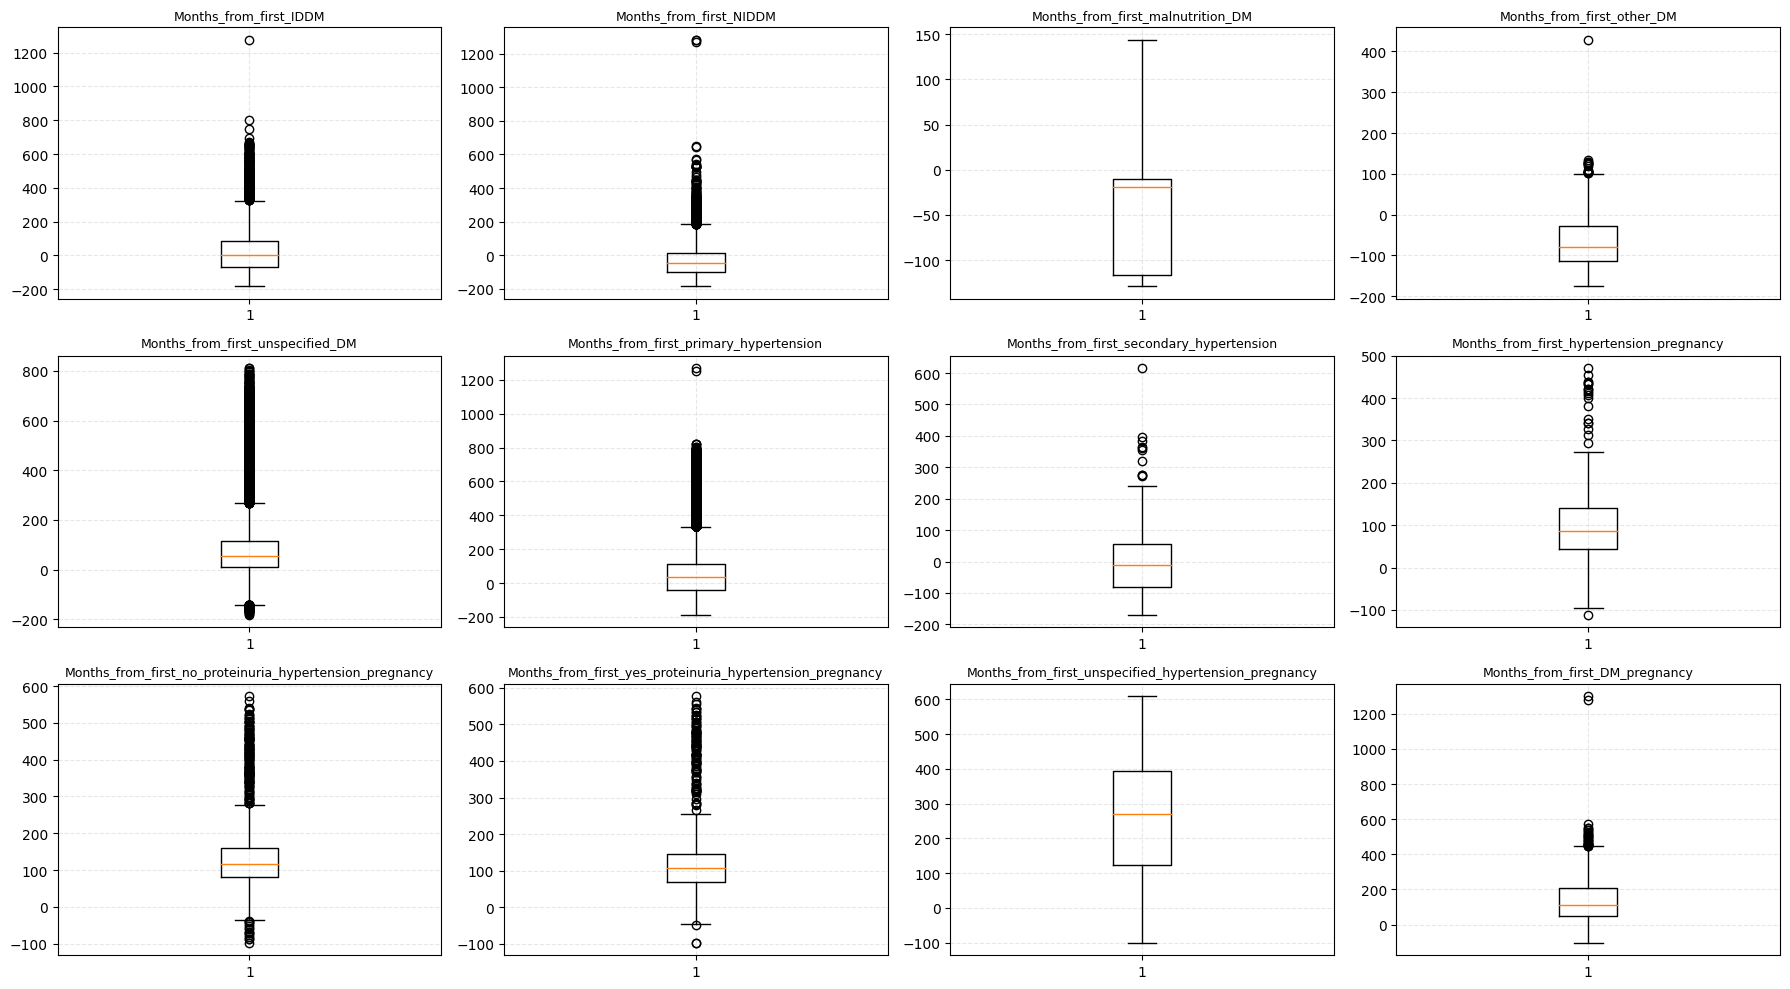

In [22]:
months_from_first_cols = [
    "Months_from_first_IDDM",
    "Months_from_first_NIDDM",
    "Months_from_first_malnutrition_DM",
    "Months_from_first_other_DM",
    "Months_from_first_unspecified_DM",
    "Months_from_first_primary_hypertension",
    "Months_from_first_secondary_hypertension",
    "Months_from_first_hypertension_pregnancy",
    "Months_from_first_no_proteinuria_hypertension_pregnancy",
    "Months_from_first_yes_proteinuria_hypertension_pregnancy",
    "Months_from_first_unspecified_hypertension_pregnancy",
    "Months_from_first_DM_pregnancy",
]

# ===== Example: use the generic functions with the "months_from_first" variables =====

# 1) Plot all boxplots for the months-from-first variables on a single page
months_stats = plot_boxplots_single_page(
    data=data,
    columns=months_from_first_cols,
    cols_per_row=4,
    whis=1.5,
    figsize=(18, 10),
)


In [23]:
display(months_stats.sort_values("pct_outside_non_null", ascending=False))

,Q1,Q3,IQR,lower_bound,upper_bound,non_null,within_whiskers,outside_whiskers,pct_within_non_null,pct_outside_non_null,pct_within_total_rows,pct_outside_total_rows
column,,,,,,,,,,,,
Months_from_first_no_proteinuria_hypertension_pregnancy,81.00,160.50,79.50,-38.250,279.750,836,664,172,79.425837,20.574163,0.132162,0.034235
Months_from_first_yes_proteinuria_hypertension_pregnancy,69.00,145.00,76.00,-45.000,259.000,577,464,113,80.415945,19.584055,0.092354,0.022492
Months_from_first_hypertension_pregnancy,42.75,141.00,98.25,-104.625,288.375,130,110,20,84.615385,15.384615,0.021894,0.003981
Months_from_first_unspecified_DM,12.00,115.00,103.00,-142.500,269.500,25536,23462,2074,91.878133,8.121867,4.669873,0.412809
Months_from_first_IDDM,-70.00,88.00,158.00,-307.000,325.000,5181,4881,300,94.209612,5.790388,0.971513,0.059712
Months_from_first_DM_pregnancy,51.00,209.25,158.25,-186.375,446.625,780,752,28,96.410256,3.589744,0.149678,0.005573
Months_from_first_secondary_hypertension,-82.50,57.25,139.75,-292.125,266.875,298,288,10,96.644295,3.355705,0.057323,0.001990
Months_from_first_other_DM,-115.00,-29.00,86.00,-244.000,100.000,545,527,18,96.697248,3.302752,0.104894,0.003583
Months_from_first_primary_hypertension,-38.00,111.00,149.00,-261.500,334.500,194807,189366,5441,97.206979,2.793021,37.691377,1.082976


The outliers removed in the *months-from-first* variables mostly reflect **incorrect or inconsistent timestamps**, not meaningful clinical values. Moderate removals (e.g., IDDM, NIDDM, other DM) indicate occasional recording errors, while very high counts (especially for primary hypertension and unspecified DM) suggest substantial inconsistency in diagnosis dates within the dataset. Pregnancy-related variables show fewer but still important removals, as unrealistic durations are easily identifiable given the limited biological timeframe. Overall, the removed values correspond to implausible durations rather than true medical variation, making Tukey-based cleaning appropriate for these features.



In [24]:
# 2) Clean outliers for these columns using Tukey fences
data = clean_columns_with_boxplot_outliers(
    df=data,
    columns=months_from_first_cols,
    whis=1.5,
    verbose=True,
)

Months_from_first_IDDM:
  Q1 = -70.00, Q3 = 88.00, IQR = 158.00
  Lower bound = -307.00
  Upper bound = 325.00
  Outliers removed = 300

Months_from_first_NIDDM:
  Q1 = -97.00, Q3 = 16.00, IQR = 113.00
  Lower bound = -266.50
  Upper bound = 185.50
  Outliers removed = 455

Months_from_first_malnutrition_DM:
  Q1 = -116.50, Q3 = -10.00, IQR = 106.50
  Lower bound = -276.25
  Upper bound = 149.75
  Outliers removed = 0

Months_from_first_other_DM:
  Q1 = -115.00, Q3 = -29.00, IQR = 86.00
  Lower bound = -244.00
  Upper bound = 100.00
  Outliers removed = 18

Months_from_first_unspecified_DM:
  Q1 = 12.00, Q3 = 115.00, IQR = 103.00
  Lower bound = -142.50
  Upper bound = 269.50
  Outliers removed = 2074

Months_from_first_primary_hypertension:
  Q1 = -38.00, Q3 = 111.00, IQR = 149.00
  Lower bound = -261.50
  Upper bound = 334.50
  Outliers removed = 5441

Months_from_first_secondary_hypertension:
  Q1 = -82.50, Q3 = 57.25, IQR = 139.75
  Lower bound = -292.12
  Upper bound = 266.88
  Ou

## Remaining Negative Values

After applying the clinical rules and the Tukey-based cleaning, a final check is needed to verify whether any variables still contain **negative values**. Since negative values are often a strong indicator of data-entry issues or invalid measurements (except for specially defined cases), inspecting them helps ensure that no inconsistent or unexpected values remain in the dataset. In this section, we identify all columns that still contain negative entries so we can decide whether further cleaning or manual inspection is required.


In [25]:
# Identify columns that still contain negative values
negative_columns = [
    col for col in data.columns
    if pd.api.types.is_numeric_dtype(data[col]) and (data[col] < 0).any()
]

# Display counts of negative values per column
neg_counts = {
    col: int((data[col] < 0).sum())
    for col in negative_columns
}

pd.DataFrame.from_dict(neg_counts, orient="index", columns=["negative_count"])


,negative_count
Elapsed_time_visit0_death0,467376
Months_from_first_IDDM,2526
Months_from_first_NIDDM,30203
Months_from_first_malnutrition_DM,6
Months_from_first_other_DM,458
Months_from_first_unspecified_DM,3414
Months_from_first_primary_hypertension,60450
Months_from_first_secondary_hypertension,157
Months_from_first_hypertension_pregnancy,16
Months_from_first_no_proteinuria_hypertension_pregnancy,25


The remaining negative values appear only in two groups of variables.  
The first is `Elapsed_time_visit0_death0`, which is an *outcome variable* representing the time between the baseline visit and death. Negative values in this context simply indicate individuals who were still alive at the time of censoring, so these values are expected and do not require cleaning.

All other columns with negative values belong to the **months-from-first** group.  
For these variables, negative values are meaningful because they represent the number of months *before* the baseline visit in which the first diagnosis occurred. Therefore, a negative duration is legitimate and indicates that the condition was diagnosed prior to visit 0.  


## All Numbers to Float

To ensure consistency across the dataset and avoid unwanted type mismatches during modeling, we convert all numeric columns to the `float` type. This guarantees a uniform representation for integers, booleans encoded as numbers, and continuous features, simplifying downstream processing and improving compatibility with most machine learning libraries.

In [26]:
# Convert all numeric columns to float
numeric_cols = data.select_dtypes(include="number").columns
data[numeric_cols] = data[numeric_cols].astype(float)

print("All numeric columns converted to float.")


All numeric columns converted to float.


## New Labels Creation

## PCA?

## Qualche plot (magari sui label)

# Exporting the Datasets

In this section, we export all the final datasets produced during the preprocessing pipeline. We provide both:

- **clean, label-free datasets**, suitable for model training and feature engineering, and  
- **label-augmented datasets**, each containing a specific target definition depending on the research question and the classification task of interest.

This separation allows for flexible use of the data in different modelling frameworks and ensures full reproducibility of the preprocessing workflow.


In [27]:
# Base directory where all cleaned datasets will be exported.
base_dir = Path(main_dir) / "Datasets" / "Cleaned_UKDataset"
base_dir.mkdir(exist_ok=True)  # Creates the folder if it does not exist (safe operation)

Before exporting the cleaned dataset, we reorganize the column order so that the structure is clear and consistent for any downstream analysis. The ordering we use is:

1. **Binary numeric columns**  
   These include all variables with exactly two unique values.  
   Although the dataset contains one binary *label* column, we intentionally **place the label at the very end**, not at the beginning with the other binary features.

2. **Continuous or multi-valued numeric columns**  
   These are the main quantitative variables (clinical, anthropometric, laboratory, etc.).  
   Keeping them grouped together ensures a predictable and readable layout.

3. **Other column types**  
   In our final cleaned dataset, no additional categorical, text, or datetime columns remain.  
   Outcome variables have been removed, except for the **binary label**, which is placed as the final column.

This ordering step does not alter the data but ensures a cleaner structure and makes the dataset easier to use in modeling workflows.


In [28]:
# Build the final column order:
#   1. binary numeric columns
#   2. continuous/multi-valued numeric columns
#   3. all other columns (categorical, datetime, text...)

num_data = data.select_dtypes(include="number")

unique_counts = num_data.nunique()
binary_cols = unique_counts[unique_counts == 2].index.tolist()
non_binary_cols = unique_counts[unique_counts > 2].index.tolist()

# Other (non-numeric) columns, in original order
other_cols = [
    col for col in data.columns 
    if col not in binary_cols + non_binary_cols
]

ordered_cols = binary_cols + non_binary_cols + other_cols
data = data[ordered_cols]

## Dataset Without Labels

In [29]:
data_without_labels = data.drop(columns=out_cols)

output_path = base_dir / "UKdata_clean_no_labels.csv"
data_without_labels.to_csv(output_path, index=False)

print(f"Dataset without labels saved to: {output_path}")


Dataset without labels saved to: /Users/angelo/Desktop/Code/clinical-data-encoding_vae/Datasets/Cleaned_UKDataset/UKdata_clean_no_labels.csv


## Dataset With label_10

In [30]:
# --- Build final dataset with label_10 only ---

# 1. Remove all outcome columns except label_10
out_cols_to_drop = [col for col in out_cols if col != "label_10"]
data_with_label_10 = data.drop(columns=out_cols_to_drop, errors="ignore")

# 2. Remove rows where label_10 is null
data_with_label_10 = data_with_label_10.dropna(subset=["label_10"])

# 3. Move label_10 to the end (without changing the order of all other columns)
cols = [col for col in data_with_label_10.columns if col != "label_10"]
cols.append("label_10")
data_with_label_10 = data_with_label_10[cols]

# 4. Export the dataset
output_path = base_dir / "UKdata_clean_with_label_10.csv"
data_with_label_10.to_csv(output_path, index=False)

print(f"Dataset with label_10 saved to: {output_path}")


Dataset with label_10 saved to: /Users/angelo/Desktop/Code/clinical-data-encoding_vae/Datasets/Cleaned_UKDataset/UKdata_clean_with_label_10.csv
